# Bank of England Assessment: Allocation of Supervisory Resources for Insurance Firms
This Notebook analyze data and offer insights in response to the need for an efficient allocation of supervisory resources. The analysis takes into account several metrics mentioned in the assessment file, such as Outliers from the Norm, Changing Business Profile, and Firm Size.

Some typical metrics have been provided in the attached data sheets. These include: 
- Gross Written Premium (GWP) – total revenue written by an insurer. Equivalent of turnover for a non-insurance firm. 
- Net Written Premium (NWP) – GWP less reinsurance. NWP / GWP will show how much of the firm’s risk is being passed on to reinsurers. 
- SCR coverage ratio – a measure of whether a firm is meeting its prudential capital requirements. Greater than 100% means the firm is holding enough capital to meet the requirement. The size of the buffer (i.e. surplus over 100%) can be important. 
- Gross claims incurred – a large cost to an insurer. Monitoring how these change over time for a firm is vital. 
- Net combined ratio – (incurred losses plus expenses) / earned premiums. This is a ratio that can indicate the profitability of a firm. If this is less than 100% it indicates a profit. 


In [1]:
#Import all necessary libraries
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Load the dataset
df1 = pd.read_excel("Analyst_Data_Science_Technical_Assessment_Data.xlsx", sheet_name="Dataset 1 - General")
df2 = pd.read_excel("Analyst_Data_Science_Technical_Assessment_Data.xlsx", sheet_name="Dataset 2 - Underwriting")
#Users can update with their own dataset filename here

In [3]:
#display all the columns in the dataframe
pd.set_option('display.max_columns', None)

In [4]:
# Preprocess the dataframe to clean and modify for further analysis
# Rename the first column for df1
df1.rename(columns={'Unnamed: 0': 'Firms'}, inplace=True)
#create a list of relevant columns
columns_to_keep = ['Firms', 'NWP (£m) ', 'NWP (£m) .1', 'NWP (£m) .2', 'NWP (£m) .3', 'NWP (£m) .4','SCR coverage ratio', 
                   'SCR coverage ratio.1', 'SCR coverage ratio.2', 'SCR coverage ratio.3', 'SCR coverage ratio.4', 'GWP (£m)', 
                   'GWP (£m).1', 'GWP (£m).2', 'GWP (£m).3', 'GWP (£m).4']
#output df1 with relevant columns
df1 = df1[columns_to_keep] 
# Rename the first column for df2
df2.rename(columns={'Unnamed: 0': 'Firms'}, inplace=True)
#create a list of relevant columns
columns_to_keep1 = ['Firms','Gross claims incurred (£m)', 'Gross claims incurred (£m).1', 'Gross claims incurred (£m).2', 
                    'Gross claims incurred (£m).3', 'Gross claims incurred (£m).4','Net combined ratio', 'Net combined ratio.1', 
                    'Net combined ratio.2', 'Net combined ratio.3', 'Net combined ratio.4']
#output df2 with relevant columns
df2 = df2[columns_to_keep1]

In [5]:
#Print first 10 rows of df1
df1.head(10)

,Firms,NWP (£m),NWP (£m) .1,NWP (£m) .2,NWP (£m) .3,NWP (£m) .4,SCR coverage ratio,SCR coverage ratio.1,SCR coverage ratio.2,SCR coverage ratio.3,SCR coverage ratio.4,GWP (£m),GWP (£m).1,GWP (£m).2,GWP (£m).3,GWP (£m).4
0,NaN,2016YE,2017YE,2018YE,2019YE,2020YE,2016YE,2017YE,2018YE,2019YE,2020YE,2016YE,2017YE,2018YE,2019YE,2020YE
1,Firm 1,-17754.100486,0,0,0,0,0.16252,55887003.057573,0,0,0,46.76803,0,0,0,0
2,Firm 2,9.244369,0.098771,40.812426,35.643071,13.626145,5.648647,3.683321,10.239507,5.79278,3.170682,41.794375,6.185296,11.578801,3.891801,16.723242
3,Firm 3,0,0.80613,36.620199,86.630018,54.74418,1.135498,1.713763,1.222781,1.348312,0.245283,0,68.10515,138.083316,148.586347,38.119418
4,Firm 4,19677.453353,41072.816156,20885.506445,14719.672914,49204.465136,0.679158,1.224834,2.699102,2.025206,1.195829,43375.80696,23689.616367,68276.763997,41081.453449,37761.883321
5,Firm 5,128.812208,10.407371,79.579663,79.423623,61.727295,1.463499,4.963118,3.2328,4.342353,1.6186,80.183916,55.798336,55.465113,18.000652,32.277535
6,Firm 6,3091.392118,3357.934035,3215.472967,53.217589,5969.707516,0.04205,0.620649,1.104387,2.233822,2.497964,1966.063119,1199.65707,4061.617189,7464.344112,4209.115926
7,Firm 7,3148.478356,3307.129485,713.84642,18232.37651,6486.658898,1.649018,0.079283,1.911233,2.296575,0.103713,4169.537704,12689.066336,5814.003842,4224.697702,16183.565614
8,Firm 8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Firm 9,15.279748,15.175538,27.793658,0.354322,6.464531,3.486425,2.420336,0.604868,3.929799,0.25722,33.268663,24.408694,31.896965,24.27647,7.422013


In [6]:
#Print first 10 rows of df2
df2.head(10)

,Firms,Gross claims incurred (£m),Gross claims incurred (£m).1,Gross claims incurred (£m).2,Gross claims incurred (£m).3,Gross claims incurred (£m).4,Net combined ratio,Net combined ratio.1,Net combined ratio.2,Net combined ratio.3,Net combined ratio.4
0,NaN,2016YE,2017YE,2018YE,2019YE,2020YE,2016YE,2017YE,2018YE,2019YE,2020YE
1,Firm 1,0,0.005515,0,0,0,0,71.298841,0,0,0
2,Firm 2,44.467865,29.489599,34.100482,0,0,1.276296,2.176071,0.687316,0,0
3,Firm 3,0,0,0,0,0,0,0,0,0,0
4,Firm 4,14.340938,71.062447,87.912471,42.280402,3.668494,0.672481,1.986952,1.841528,3.817221,-3.548731
5,Firm 5,48.738606,425.748869,691.379669,174.10126,5.927624,0.509871,0.087592,2.403635,1.240876,1.869668
6,Firm 6,125.076792,457.319722,364.148755,257.332452,268.527873,0.280969,0.496601,0.700045,1.523202,0.384564
7,Firm 7,0,0,0,0,0,0,0,0,0,0
8,Firm 8,0.107354,-0.027761,-0.177631,0,0,0.640541,1.106219,-0.962193,0.193519,0
9,Firm 9,213.496532,87.593124,193.063868,78.949374,0,1.500627,1.62488,1.103711,1.856405,0


In [7]:
#merge the dataset for analysis
df = pd.merge(df1, df2, on='Firms')
#drop first row containing years for clarified dataframe
df = df.drop(0)
# Reset index
df.reset_index(drop=True, inplace=True)
#print df column names
df.columns

Index(['Firms', 'NWP (£m) ', 'NWP (£m) .1', 'NWP (£m) .2', 'NWP (£m) .3',
       'NWP (£m) .4', 'SCR coverage ratio', 'SCR coverage ratio.1',
       'SCR coverage ratio.2', 'SCR coverage ratio.3', 'SCR coverage ratio.4',
       'GWP (£m)', 'GWP (£m).1', 'GWP (£m).2', 'GWP (£m).3', 'GWP (£m).4',
       'Gross claims incurred (£m)', 'Gross claims incurred (£m).1',
       'Gross claims incurred (£m).2', 'Gross claims incurred (£m).3',
       'Gross claims incurred (£m).4', 'Net combined ratio',
       'Net combined ratio.1', 'Net combined ratio.2', 'Net combined ratio.3',
       'Net combined ratio.4'],
      dtype='object')

In [8]:
#Print first 10 rows of the merged dataframe
df.head(10)

,Firms,NWP (£m),NWP (£m) .1,NWP (£m) .2,NWP (£m) .3,NWP (£m) .4,SCR coverage ratio,SCR coverage ratio.1,SCR coverage ratio.2,SCR coverage ratio.3,SCR coverage ratio.4,GWP (£m),GWP (£m).1,GWP (£m).2,GWP (£m).3,GWP (£m).4,Gross claims incurred (£m),Gross claims incurred (£m).1,Gross claims incurred (£m).2,Gross claims incurred (£m).3,Gross claims incurred (£m).4,Net combined ratio,Net combined ratio.1,Net combined ratio.2,Net combined ratio.3,Net combined ratio.4
0,Firm 1,-17754.100486,0,0,0,0,0.16252,55887003.057573,0,0,0,46.76803,0,0,0,0,0,0.005515,0,0,0,0,71.298841,0,0,0
1,Firm 2,9.244369,0.098771,40.812426,35.643071,13.626145,5.648647,3.683321,10.239507,5.79278,3.170682,41.794375,6.185296,11.578801,3.891801,16.723242,44.467865,29.489599,34.100482,0,0,1.276296,2.176071,0.687316,0,0
2,Firm 3,0,0.80613,36.620199,86.630018,54.74418,1.135498,1.713763,1.222781,1.348312,0.245283,0,68.10515,138.083316,148.586347,38.119418,0,0,0,0,0,0,0,0,0,0
3,Firm 4,19677.453353,41072.816156,20885.506445,14719.672914,49204.465136,0.679158,1.224834,2.699102,2.025206,1.195829,43375.80696,23689.616367,68276.763997,41081.453449,37761.883321,14.340938,71.062447,87.912471,42.280402,3.668494,0.672481,1.986952,1.841528,3.817221,-3.548731
4,Firm 5,128.812208,10.407371,79.579663,79.423623,61.727295,1.463499,4.963118,3.2328,4.342353,1.6186,80.183916,55.798336,55.465113,18.000652,32.277535,48.738606,425.748869,691.379669,174.10126,5.927624,0.509871,0.087592,2.403635,1.240876,1.869668
5,Firm 6,3091.392118,3357.934035,3215.472967,53.217589,5969.707516,0.04205,0.620649,1.104387,2.233822,2.497964,1966.063119,1199.65707,4061.617189,7464.344112,4209.115926,125.076792,457.319722,364.148755,257.332452,268.527873,0.280969,0.496601,0.700045,1.523202,0.384564
6,Firm 7,3148.478356,3307.129485,713.84642,18232.37651,6486.658898,1.649018,0.079283,1.911233,2.296575,0.103713,4169.537704,12689.066336,5814.003842,4224.697702,16183.565614,0,0,0,0,0,0,0,0,0,0
7,Firm 8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.107354,-0.027761,-0.177631,0,0,0.640541,1.106219,-0.962193,0.193519,0
8,Firm 9,15.279748,15.175538,27.793658,0.354322,6.464531,3.486425,2.420336,0.604868,3.929799,0.25722,33.268663,24.408694,31.896965,24.27647,7.422013,213.496532,87.593124,193.063868,78.949374,0,1.500627,1.62488,1.103711,1.856405,0
9,Firm 10,404.116022,3882.087306,6640.433866,5196.618355,221.986516,1.249246,0.66918,1.957921,1.112032,0.598787,678.22377,9887.800616,9002.108895,10552.58669,882.479158,3.671436,100.897254,138.345633,122.984554,189.697324,0.795576,1.145839,0.493554,1.510425,0.074722


Task I:
- Using the data provided, please analyse this data using a programming language of your choosing and produce a short report, including tables and charts, to highlight which firms should receive the most attention, according to the metrics above. 

Here, we will performs various functions such as data analysis, mean metrics calculation, firm identification based on predetermined criteria, summary statistics generation, and visualization of the relationship between two key metrics. Lastly, it prints the list of firms that require attention based on the metrics as well as the summary statistics. 

In [9]:
# Convert columns to numeric
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
#Remove leading and trailing whitespaces from column names
df.columns = df.columns.str.strip()
# Data cleaning to remove missing values and fill NA/NaN values with 0
df.dropna(subset=['NWP (£m)', 'SCR coverage ratio', 'GWP (£m)', 'Gross claims incurred (£m)', 'Net combined ratio'], inplace=True)  
df.fillna(0, inplace=True) 

In [10]:
# Perform Data type conversion to float for easier mean calculation
df['NWP (£m)'] = df['NWP (£m)'].astype(float)
df['SCR coverage ratio'] = df['SCR coverage ratio'].astype(float)
df['GWP (£m)'] = df['GWP (£m)'].astype(float)
df['Gross claims incurred (£m)'] = df['Gross claims incurred (£m)'].astype(float)
df['Net combined ratio'] = df['Net combined ratio'].astype(float)
# Calculate average values for each metric for all the yearsYE and input these values in separate columns in the dataframe
df['avg_NWP'] = df.filter(like='NWP').mean(axis=1)
df['avg_GWP'] = df.filter(like='GWP').mean(axis=1)
df['avg_SCR_coverage_ratio'] = df.filter(like='SCR coverage ratio').mean(axis=1)
df['avg_Gross_claims_incurred'] = df.filter(like='Gross claims incurred').mean(axis=1)
df['avg_Net_combined_ratio'] = df.filter(like='Net combined ratio').mean(axis=1)

In [11]:
#print top 5 rows with additional columns
df.head(5)

,Firms,NWP (£m),NWP (£m) .1,NWP (£m) .2,NWP (£m) .3,NWP (£m) .4,SCR coverage ratio,SCR coverage ratio.1,SCR coverage ratio.2,SCR coverage ratio.3,SCR coverage ratio.4,GWP (£m),GWP (£m).1,GWP (£m).2,GWP (£m).3,GWP (£m).4,Gross claims incurred (£m),Gross claims incurred (£m).1,Gross claims incurred (£m).2,Gross claims incurred (£m).3,Gross claims incurred (£m).4,Net combined ratio,Net combined ratio.1,Net combined ratio.2,Net combined ratio.3,Net combined ratio.4,avg_NWP,avg_GWP,avg_SCR_coverage_ratio,avg_Gross_claims_incurred,avg_Net_combined_ratio
0,Firm 1,-17754.100486,0.0,0.0,0.0,0.0,0.162520,55887003.057573,0.0,0.0,0.0,46.768030,0.0,0.0,0.0,0.0,0.000000,0.005515,0.0,0.0,0.0,0.000000,71.298841,0.0,0.0,0.0,-3550.820097,9.353606,11177400.644019,0.001103,14.259768
1,Firm 2,9.244369,0.098771,40.812426,35.643071,13.626145,5.648647,3.683321,10.239507,5.79278,3.170682,41.794375,6.185296,11.578801,3.891801,16.723242,44.467865,29.489599,34.100482,0.0,0.0,1.276296,2.176071,0.687316,0.0,0.0,19.884957,16.034703,5.706987,21.611589,0.827937
2,Firm 3,0.000000,0.80613,36.620199,86.630018,54.74418,1.135498,1.713763,1.222781,1.348312,0.245283,0.000000,68.10515,138.083316,148.586347,38.119418,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,35.760105,78.578846,1.133127,0.0,0.0
3,Firm 4,19677.453353,41072.816156,20885.506445,14719.672914,49204.465136,0.679158,1.224834,2.699102,2.025206,1.195829,43375.806960,23689.616367,68276.763997,41081.453449,37761.883321,14.340938,71.062447,87.912471,42.280402,3.668494,0.672481,1.986952,1.841528,3.817221,-3.548731,29111.982801,42837.104819,1.564826,43.85295,0.95389
4,Firm 5,128.812208,10.407371,79.579663,79.423623,61.727295,1.463499,4.963118,3.2328,4.342353,1.6186,80.183916,55.798336,55.465113,18.000652,32.277535,48.738606,425.748869,691.379669,174.10126,5.927624,0.509871,0.087592,2.403635,1.240876,1.869668,71.990032,48.34511,3.124074,269.179206,1.222328


In [12]:
'''Here I have chosen 2016YE data to compare from the mean values to check how much is the deviation and whether a Firm is an outlier.
   Users can change it to preferred year data columns.
   Users can also change the criteria for identifying firms needing attention according to their specific requirements.
'''
# Identify firms needing attention and deviating significantly based on metrics
outliers = df[(df['NWP (£m) .1'] > df['avg_NWP'].quantile(0.1)) |
              (df['avg_SCR_coverage_ratio'] < 100) |
              (df['Gross claims incurred (£m).1'] > df['avg_Gross_claims_incurred'].quantile(0.9)) |
              (df['avg_Net_combined_ratio'] > 100)]

In [13]:
# Generate table to print outliers and Firms that need most attention from Supervisory team
print("Firms that should receive the most attention based on metrics:")
print(outliers)
# Specify the filename for the CSV file
csv_filename = 'outliers.csv'

# Save the DataFrame to a CSV file
outliers.to_csv(csv_filename, index=False)

Firms that should receive the most attention based on metrics:
        Firms      NWP (£m)   NWP (£m) .1   NWP (£m) .2   NWP (£m) .3  \
1      Firm 2      9.244369      0.098771     40.812426     35.643071   
2      Firm 3      0.000000       0.80613     36.620199     86.630018   
3      Firm 4  19677.453353  41072.816156  20885.506445  14719.672914   
4      Firm 5    128.812208     10.407371     79.579663     79.423623   
5      Firm 6   3091.392118   3357.934035   3215.472967     53.217589   
..        ...           ...           ...           ...           ...   
320  Firm 321      0.000000           0.0     -0.167178     -6.813367   
321  Firm 322   3315.466643   4136.476625   2192.750865   2252.917257   
322  Firm 323      0.000000           0.0           0.0           0.0   
323  Firm 324     29.811172     21.003008      13.55174      6.145755   
324  Firm 325    108.471899     496.29603    437.217641    120.652291   

      NWP (£m) .4  SCR coverage ratio SCR coverage ratio.1  

In [14]:
# Summary statistics
summary_stats = df.describe()
# Print the report
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
           NWP (£m)  SCR coverage ratio      GWP (£m)  \
count    325.000000        3.250000e+02    325.000000   
mean     748.880569        2.072793e+04    740.351302   
std     5366.722486        3.736213e+05   3472.716920   
min   -17754.100486       -3.488211e+00    -19.777480   
25%        0.000000        5.113429e-01      0.000000   
50%        1.700359        1.629625e+00      6.010368   
75%       71.613612        2.906832e+00    157.713082   
max    75526.673293        6.735558e+06  43375.806960   

       Gross claims incurred (£m)  Net combined ratio  
count                  325.000000          325.000000  
mean                   132.566675            1.354706  
std                    537.467448           17.560436  
min                    -74.422893         -180.398579  
25%                      0.000000            0.000000  
50%                      0.769720            0.066949  
75%                     50.258854            0.870322  
max               

Plots to visualise relationship between key metrics

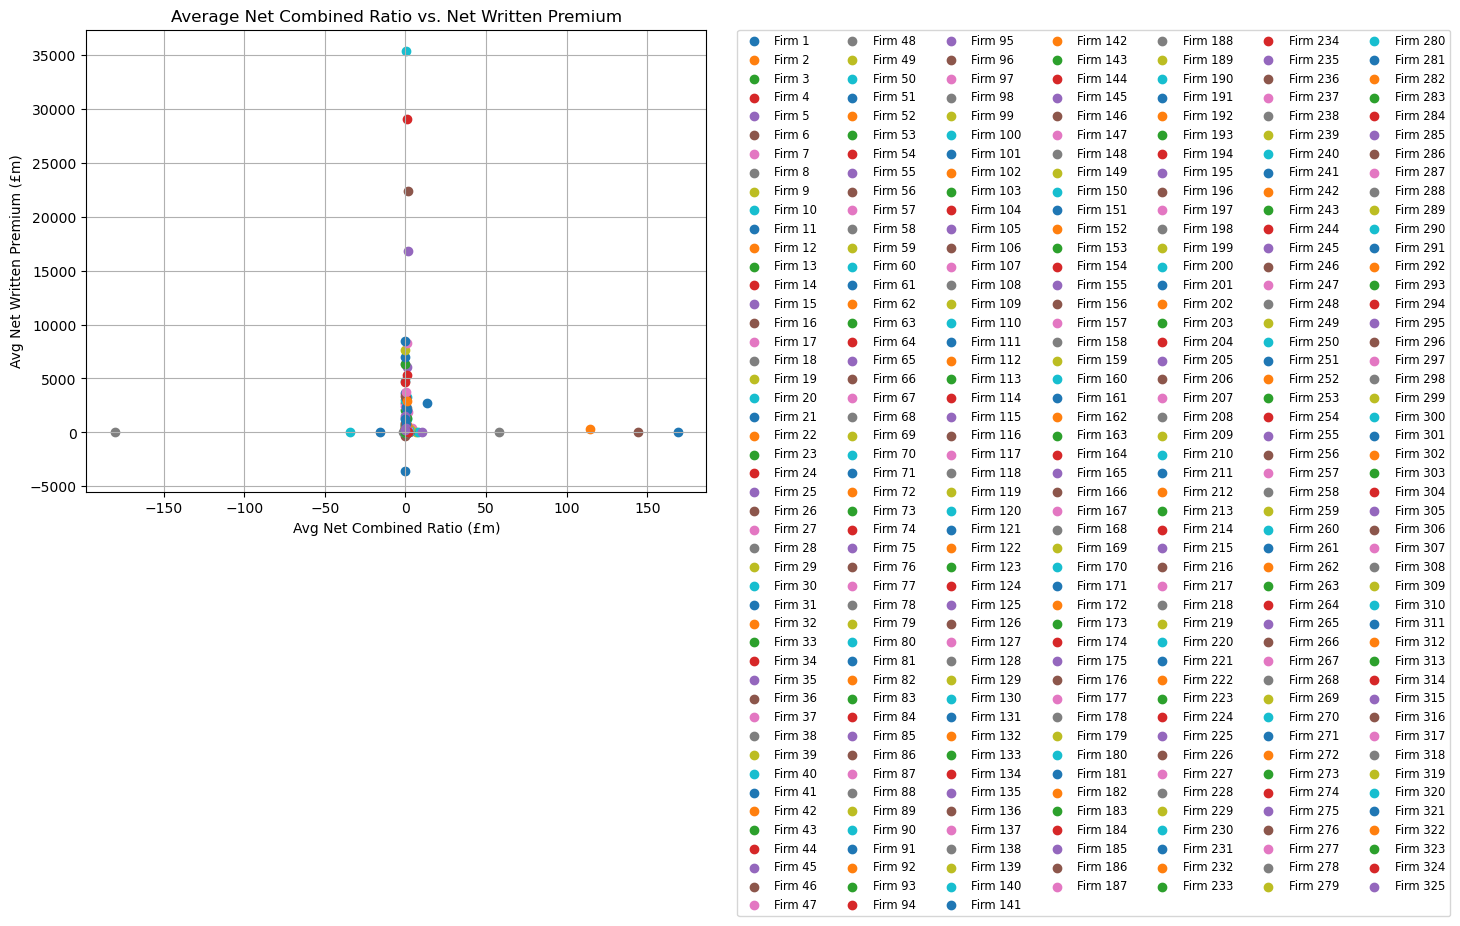

In [15]:
# Example 1: Scatter plot of Avg Net Written Premium vs Net Combined Ratio for df dataframe
# Plot each point for each firm on the scatter plot
#Users can use any other metrics instead of avg_NWP
plt.figure(figsize=(8,6))
for index, row in df.iterrows():
    plt.scatter(row['Net combined ratio'], row['avg_NWP'], label=row['Firms'])
plt.title('Average Net Combined Ratio vs. Net Written Premium')
plt.xlabel('Avg Net Combined Ratio (£m)')
plt.ylabel('Avg Net Written Premium (£m)')
# Adjust the legend to be outside the plot and divided into two columns
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=7, fontsize='small')
plt.grid(True)
plt.savefig('example_plot1.png')
plt.show()

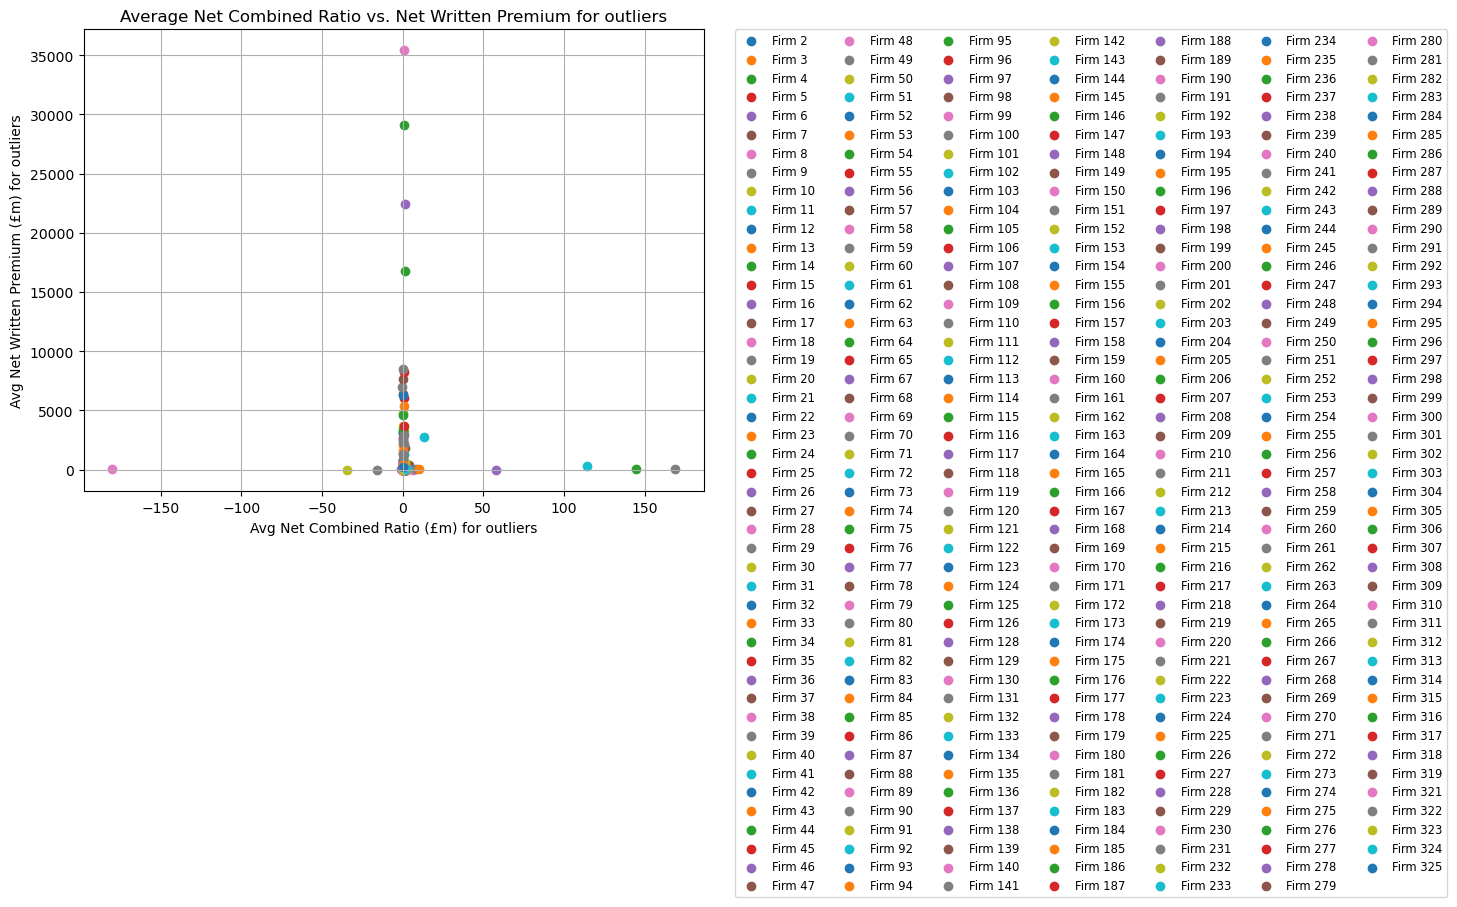

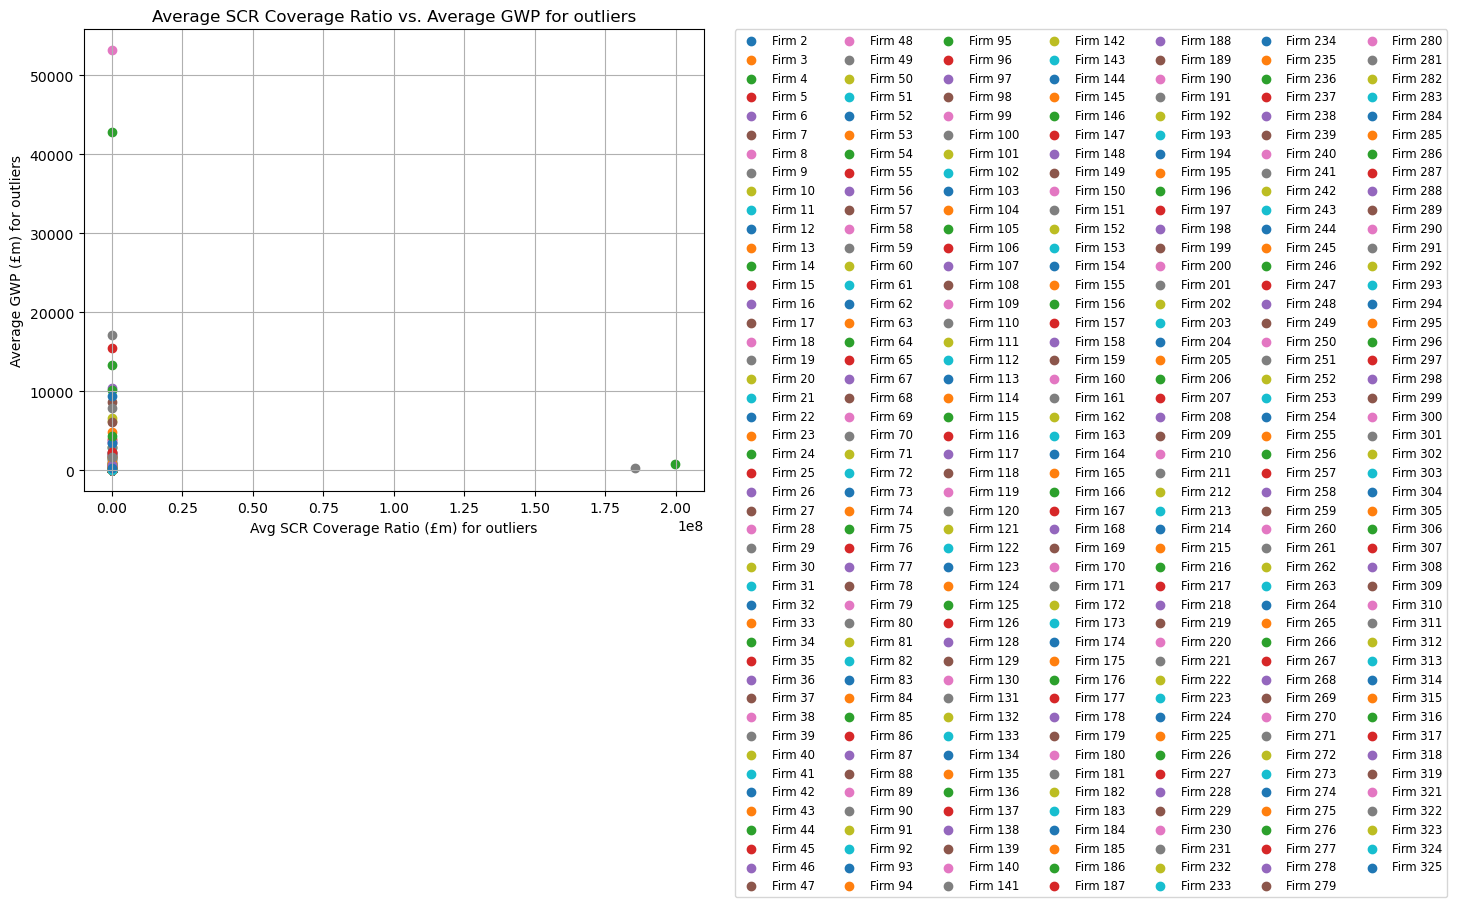

In [16]:
# Example 2: Scatter plot of Avg Net Written Premium vs Net Combined Ratio for outliers dataframe and
# Scatter plot of Avg SCR Coverage Ratio vs. Average GWP for outliers.
# Plot each point for each firm on the scatter plot
plt.figure(figsize=(8,6))
for index, row in outliers.iterrows():
    plt.scatter(row['Net combined ratio'], row['avg_NWP'], label=row['Firms'])
plt.title('Average Net Combined Ratio vs. Net Written Premium for outliers')
plt.xlabel('Avg Net Combined Ratio (£m) for outliers')
plt.ylabel('Avg Net Written Premium (£m) for outliers')
# Adjust the legend to be outside the plot and divided into two columns
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=7, fontsize='small')
plt.grid(True)
plt.savefig('example_plot2.png')
plt.show()

plt.figure(figsize=(8,6))
for index, row in outliers.iterrows():
    plt.scatter(row['avg_SCR_coverage_ratio'], row['avg_GWP'], label=row['Firms'])
plt.title('Average SCR Coverage Ratio vs. Average GWP for outliers')
plt.xlabel('Avg SCR Coverage Ratio (£m) for outliers')
plt.ylabel('Average GWP (£m) for outliers')
# Adjust the legend to be outside the plot and divided into two columns
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=7, fontsize='small')
plt.grid(True)
plt.savefig('example_plot3.png')
plt.show()

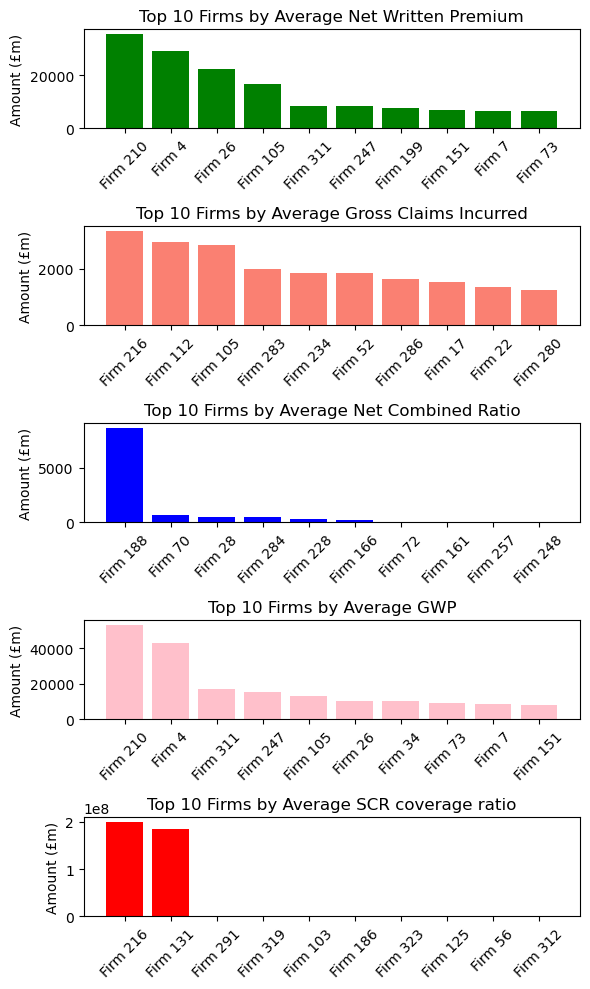

In [17]:
# Example 3: Bar plot to show top 10 firms that need supervisory attention based on Avg Net Combined Ratio, Avg NWP and Gross claims 
#incurred (£m) from outliers. 
# Plot each point for each firm on the scatter plot
#Users can use any other metrics instead of Avg Net Combined Ratio, NWP and Gross claims incurred (£m)
# Sort outliers dataframe based on different metrics
df_sorted1 = outliers.sort_values(by='avg_NWP', ascending=False)
df_sorted2 = outliers.sort_values(by='avg_Gross_claims_incurred', ascending=False)
df_sorted3 = outliers.sort_values(by='avg_Net_combined_ratio', ascending=False)
df_sorted4 = outliers.sort_values(by='avg_GWP', ascending=False)
df_sorted5 = outliers.sort_values(by='avg_SCR_coverage_ratio', ascending=False)

# Select the top 10 firms for each metric
top_10_firms_NWP = df_sorted1.head(10)
top_10_firms_GCI = df_sorted2.head(10)
top_10_firms_NCR = df_sorted3.head(10)
top_10_firms_GWP = df_sorted4.head(10)
top_10_firms_SCR = df_sorted5.head(10)

# Create subplots for three bar charts
fig, axs = plt.subplots(5, 1, figsize=(6, 10))

# Plot first bar chart: Net Written Premium
axs[0].bar(top_10_firms_NWP['Firms'], top_10_firms_NWP['avg_NWP'], color='green')
axs[0].set_title('Top 10 Firms by Average Net Written Premium')
axs[0].set_ylabel('Amount (£m)')
axs[0].tick_params(axis='x', rotation=45)

# Plot second bar chart: Gross Claims Incurred
axs[1].bar(top_10_firms_GCI['Firms'], top_10_firms_GCI['avg_Gross_claims_incurred'], color='salmon')
axs[1].set_title('Top 10 Firms by Average Gross Claims Incurred')
axs[1].set_ylabel('Amount (£m)')
axs[1].tick_params(axis='x', rotation=45)

# Plot third bar chart: Average Net Combined Ratio
axs[2].bar(top_10_firms_NCR['Firms'], top_10_firms_NCR['avg_Net_combined_ratio'], color='blue')
axs[2].set_title('Top 10 Firms by Average Net Combined Ratio')
axs[2].set_ylabel('Amount (£m)')
axs[2].tick_params(axis='x', rotation=45)

# Plot third bar chart: Average GWP
axs[3].bar(top_10_firms_GWP['Firms'], top_10_firms_GWP['avg_GWP'], color='pink')
axs[3].set_title('Top 10 Firms by Average GWP')
axs[3].set_ylabel('Amount (£m)')
axs[3].tick_params(axis='x', rotation=45)

# Plot third bar chart: Average SCR coverage Ratio
axs[4].bar(top_10_firms_SCR['Firms'], top_10_firms_SCR['avg_SCR_coverage_ratio'], color='red')
axs[4].set_title('Top 10 Firms by Average SCR coverage ratio')
axs[4].set_ylabel('Amount (£m)')
axs[4].tick_params(axis='x', rotation=45)
# Adjust layout
plt.tight_layout()
plt.savefig('example_plot4.png')
plt.show()



/Users/shubhanijain/anaconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shubhanijain/anaconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shubhanijain/anaconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shubhanijain/anaconda3/envs/ml/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

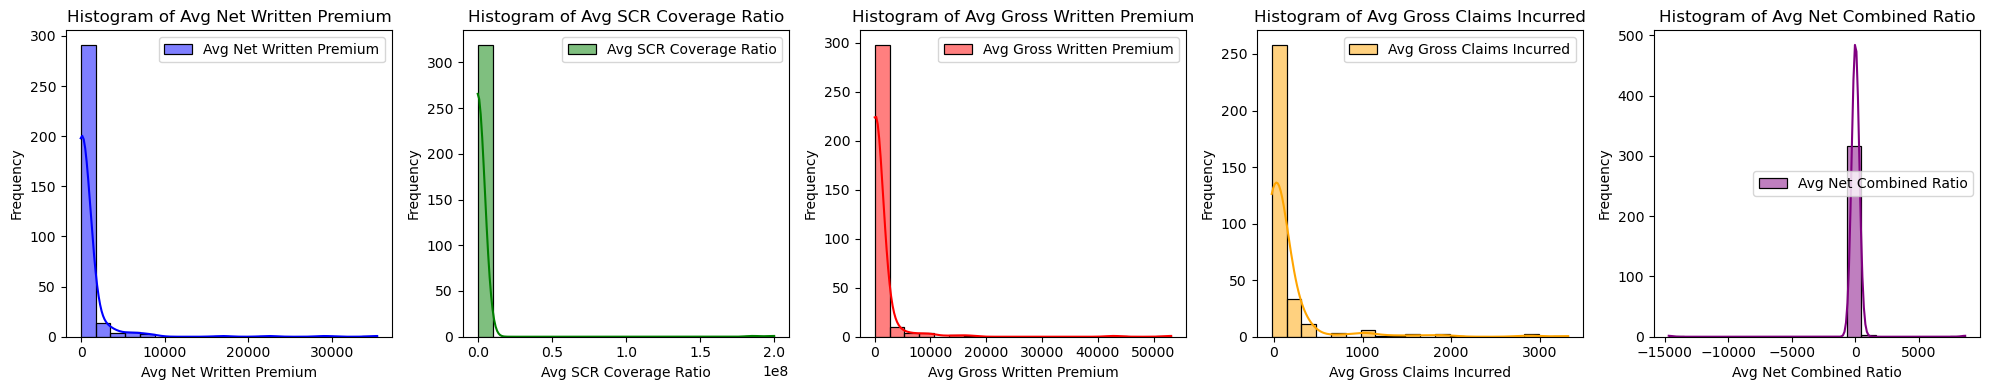

In [18]:
#Example 4:  Hist Plots to displays each metric separately. Each histogram includes 20 bins and a kernel density estimate. 
metrics1 = ['avg_NWP', 'avg_SCR_coverage_ratio', 'avg_GWP', 'avg_Gross_claims_incurred', 'avg_Net_combined_ratio']
metric_labels1 = ['Avg Net Written Premium', 'Avg SCR Coverage Ratio', 'Avg Gross Written Premium', 'Avg Gross Claims Incurred', 
                 'Avg Net Combined Ratio']
colors1 = ['blue', 'green', 'red', 'orange', 'purple']

fig, axes = plt.subplots(1, len(metrics1), figsize=(20, 4))

# Plot histograms for each metric using subplots
for i, (metric1, label, color) in enumerate(zip(metrics1, metric_labels1, colors1)):
    sns.histplot(outliers[metric1], bins=20, kde=True, color=color, label=label, ax=axes[i])
    axes[i].set_title(f'Histogram of {label}')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.savefig('example_plot5.png')
plt.show()

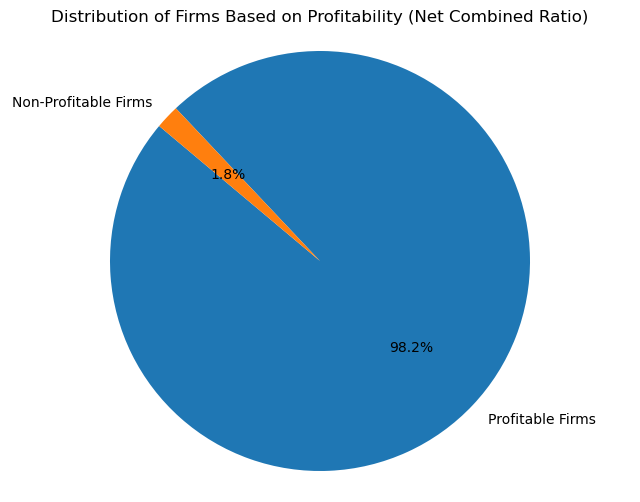

In [19]:
#Example 5:  Pie Chart to displays each profitable firms 
# Categorizing firms based on profitability
profitable_firms = sum(df['avg_Net_combined_ratio'] < 100)
non_profitable_firms = sum(df['avg_Net_combined_ratio'] >= 100)

# Create labels and sizes for the pie chart
labels = ['Profitable Firms', 'Non-Profitable Firms']
sizes = [profitable_firms, non_profitable_firms]

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Firms Based on Profitability (Net Combined Ratio)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.savefig('example_plot6.png')
plt.show()

Task II:
- Please consider using relevant ML techniques to draw out further insights and present them as an annex to your report.

Depending on the nature of the issue and the analysis's goals, we can investigate different strategies such as clustering to use machine learning techniques to extract more insights from the data and present them as an annex to our report.



1. Here's an approach using clustering analysis to group firms based on their performance metrics:

This code carries out the subsequent actions:

- Chooses pertinent features to be clustered.
- Ensures that the features have the same scale by standardizing them.
- Utilises three clusters for KMeans clustering.
- Calculate centroids of each cluster
- Utilises a scatter plot to display the clusters.
- Prints each cluster's number of businesses.

/Users/shubhanijain/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


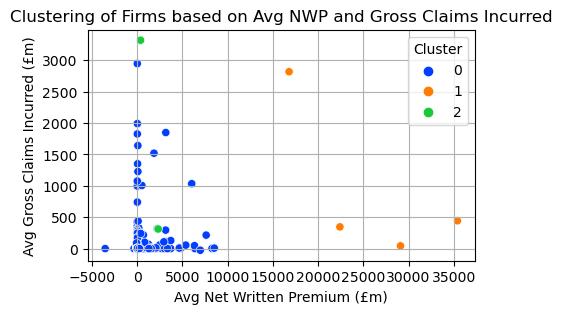

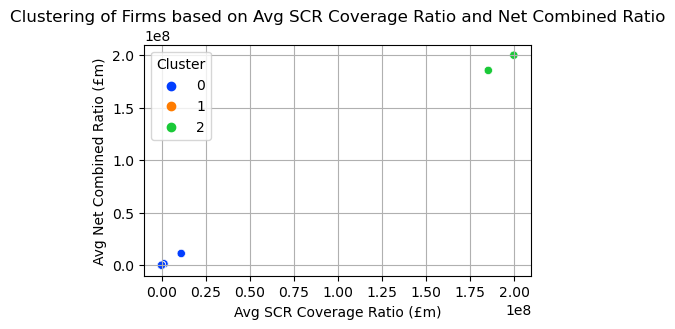

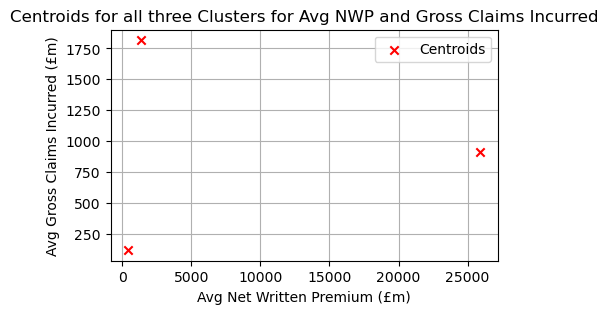

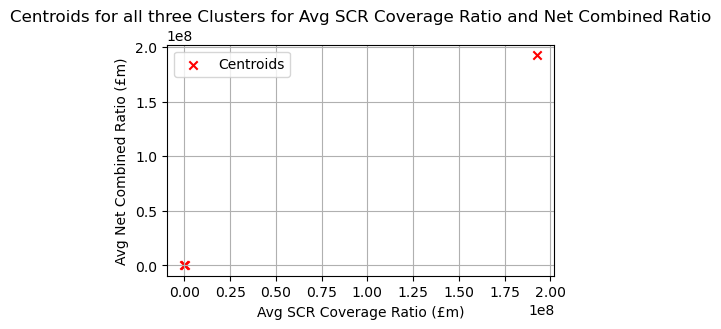

Cluster
0    319
1      4
2      2
Name: count, dtype: int64


In [20]:
''' Here I have selected the mean values of all the metrics for all years to be my features. One can change that according to 
    their preference or necessary requirements.'''
# Select relevant features for clustering
rel_features = df[['avg_NWP', 'avg_SCR_coverage_ratio', 'avg_GWP', 'avg_Gross_claims_incurred', 'avg_Net_combined_ratio']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rel_features)

# Apply K-means clustering with arbitrary k (number of clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)
cluster_labels = kmeans.labels_

# Add cluster labels to DataFrame
df['Cluster'] = cluster_labels

# Calculate the centroid of each cluster to understand the central tendencies of the data points within the cluster
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(centroids, columns=rel_features.columns)

# Visualise clusters to displays the clusters formed by the algorithm, enabling a visual interpretation of patterns within the data
plt.figure(figsize=(5, 3))
sns.scatterplot(x='avg_NWP', y='avg_Gross_claims_incurred', hue='Cluster', data=df, palette='bright', legend='full')
plt.title('Clustering of Firms based on Avg NWP and Gross Claims Incurred')
plt.xlabel('Avg Net Written Premium (£m)')
plt.ylabel('Avg Gross Claims Incurred (£m)')
plt.grid(True)
plt.savefig('example_plot1_clus.png')
plt.show()

plt.figure(figsize=(5, 3))
sns.scatterplot(x='avg_SCR_coverage_ratio', y='avg_SCR_coverage_ratio', hue='Cluster', data=df, palette='bright', legend='full')
plt.title('Clustering of Firms based on Avg SCR Coverage Ratio and Net Combined Ratio')
plt.xlabel('Avg SCR Coverage Ratio (£m)')
plt.ylabel('Avg Net Combined Ratio (£m)')
plt.grid(True)
plt.savefig('example_plot2_clus.png')
plt.show()

# Visualisation of cluster characteristics for identifying distinct centroids
plt.figure(figsize=(5, 3))
plt.scatter(cluster_centers['avg_NWP'], cluster_centers['avg_Gross_claims_incurred'], color='red', marker='x', label='Centroids')
plt.xlabel('Avg Net Written Premium (£m)')
plt.ylabel('Avg Gross Claims Incurred (£m)')
plt.title('Centroids for all three Clusters for Avg NWP and Gross Claims Incurred')
plt.grid(True)
plt.legend()
plt.savefig('example_plot3_clus.png')
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(cluster_centers['avg_SCR_coverage_ratio'], cluster_centers['avg_SCR_coverage_ratio'], color='red', marker='x', label='Centroids')
plt.xlabel('Avg SCR Coverage Ratio (£m)')
plt.ylabel('Avg Net Combined Ratio (£m)')
plt.title('Centroids for all three Clusters for Avg SCR Coverage Ratio and Net Combined Ratio')
plt.grid(True)
plt.legend()
plt.savefig('example_plot4_clus.png')
plt.show()

# Print number of firms in each cluster
print(df['Cluster'].value_counts())

Additional Task:

- Here we distinguish between genuine outliers and potential errors in reporting, we can use statistical methods such as Z-score or interquartile range (IQR). Code to identify potential errors in reporting based on Z-score:

In [21]:
# Define a function to identify potential errors in reporting based on Z-score
def identify_errors(df):
    # apply the function to each relevant column to identify potential error
    threshold_zsc = 3  # Define the threshold for Z-score
    
    zsc = np.abs((df - df.mean()) / df.std())  # Calculate Z-scores for each data point
    
    # Identify potential errors in reporting based on Z-score
    err = df[zsc > threshold_zsc]
    
    return err

# Columns to consider for outlier detection
columns_int = ['avg_NWP', 'avg_SCR_coverage_ratio', 'avg_GWP', 'avg_Gross_claims_incurred', 'avg_Net_combined_ratio']

# Create a dictionary to store potential errors for each column
err_dict = {}

for col in columns_int:
    err = identify_errors(df[col])
    err_dict[col] = err

# Print potential errors for each column
for col, errors in err_dict.items():
    print(f"Potential errors in {col}:")
    print(errors)
    print()


Potential errors in avg_NWP:
3      29111.982801
25     22409.048775
104    16788.314194
209     35411.42265
Name: avg_NWP, dtype: object

Potential errors in avg_SCR_coverage_ratio:
130     185396672.77964
215    199860575.860586
Name: avg_SCR_coverage_ratio, dtype: object

Potential errors in avg_GWP:
3      42837.104819
209    53157.315962
246    15542.935718
310    17110.301262
Name: avg_GWP, dtype: object

Potential errors in avg_Gross_claims_incurred:
16     1519.991917
21     1350.986398
51     1826.518255
104    2818.049217
111    2947.025734
215    3319.574898
233    1848.847773
282    1991.336765
285    1641.146832
Name: avg_Gross_claims_incurred, dtype: object

Potential errors in avg_Net_combined_ratio:
98    -14690.054203
187     8636.437265
Name: avg_Net_combined_ratio, dtype: object

